In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s5e1/sample_submission.csv
/kaggle/input/playground-series-s5e1/train.csv
/kaggle/input/playground-series-s5e1/test.csv


## Getting started

This notebook is adapted from `Forecasting Sticker Sales with XGB, LGB, CatBoost` by `Vishnupriya`

Thank you to the author for the inspiration and guidance in this project.

Credit : https://www.kaggle.com/code/vishnupriyagarige/forecasting-sticker-sales-with-xgb-lgb-catboost

In [2]:
train_df = pd.read_csv('/kaggle/input/playground-series-s5e1/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e1/test.csv')

In [3]:
print(train_df.shape)
print(test_df.shape)

(230130, 6)
(98550, 5)


In [4]:
train_df.head(5)

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


## Data Preprocessing

### 1. Deal with the NaN values

In [6]:
train_df[(train_df["country"] == "Canada") & (train_df['product'] == "Holographic Goose") & (train_df["store"] == "Discount Stickers")]

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
90,90,2010-01-02,Canada,Discount Stickers,Holographic Goose,NaN
180,180,2010-01-03,Canada,Discount Stickers,Holographic Goose,NaN
270,270,2010-01-04,Canada,Discount Stickers,Holographic Goose,NaN
360,360,2010-01-05,Canada,Discount Stickers,Holographic Goose,NaN
...,...,...,...,...,...,...
229680,229680,2016-12-27,Canada,Discount Stickers,Holographic Goose,NaN
229770,229770,2016-12-28,Canada,Discount Stickers,Holographic Goose,NaN
229860,229860,2016-12-29,Canada,Discount Stickers,Holographic Goose,NaN
229950,229950,2016-12-30,Canada,Discount Stickers,Holographic Goose,NaN


That's mean the NaN values is from the same store and it's useless to train these rows.

In [7]:
train_df.isna().sum().sort_values(ascending=False)

num_sold    8871
id             0
date           0
country        0
store          0
product        0
dtype: int64

In [8]:
test_df.isna().sum().sort_values(ascending=False)

id         0
date       0
country    0
store      0
product    0
dtype: int64

Drop the NaN values

In [9]:
train_df = train_df.drop_duplicates().dropna()
train_df.shape

(221259, 6)

### 2. Transform Date and Num Sold

In [10]:
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

train_df['Year'] = train_df['date'].dt.year
train_df['Month'] = train_df['date'].dt.month
train_df['Day'] = train_df['date'].dt.day

test_df['Year'] = test_df['date'].dt.year
test_df['Month'] = test_df['date'].dt.month
test_df['Day'] = test_df['date'].dt.day

train_df.drop('date',axis=1,inplace=True)
test_df.drop('date',axis=1,inplace=True)

In [11]:
train_df['num_sold'] = np.log1p(train_df['num_sold'])

In [12]:
train_df

,id,country,store,product,num_sold,Year,Month,Day
1,1,Canada,Discount Stickers,Kaggle,6.881411,2010,1,1
2,2,Canada,Discount Stickers,Kaggle Tiers,6.810142,2010,1,1
3,3,Canada,Discount Stickers,Kerneler,6.049733,2010,1,1
4,4,Canada,Discount Stickers,Kerneler Dark Mode,6.198479,2010,1,1
5,5,Canada,Stickers for Less,Holographic Goose,5.707110,2010,1,1
...,...,...,...,...,...,...,...,...
230125,230125,Singapore,Premium Sticker Mart,Holographic Goose,6.146329,2016,12,31
230126,230126,Singapore,Premium Sticker Mart,Kaggle,7.975221,2016,12,31
230127,230127,Singapore,Premium Sticker Mart,Kaggle Tiers,7.740664,2016,12,31
230128,230128,Singapore,Premium Sticker Mart,Kerneler,7.125283,2016,12,31


### 3. Transform Non-numeric columns

In [13]:
train_df = train_df.drop('id', axis = 1)
num_cols = list(train_df.select_dtypes(exclude=['object']).columns.difference(['num_sold']))
cat_cols = list(train_df.select_dtypes(include=['object']).columns)

num_cols_test = list(test_df.select_dtypes(exclude=['object']).columns.difference(['id']))
cat_cols_test = list(test_df.select_dtypes(include=['object']).columns)

In [14]:
num_cols

['Day', 'Month', 'Year']

In [15]:
cat_cols

['country', 'store', 'product']

We will handle the non-numeric objects with the LabelEncoder and transform it to numeric

In [16]:
from sklearn.preprocessing import LabelEncoder
# Initialize LabelEncoder
label_encoders = {col: LabelEncoder() for col in cat_cols}

# Apply LabelEncoder to each categorical column
for col in cat_cols:
    train_df[col] = label_encoders[col].fit_transform(train_df[col])
    test_df[col] = label_encoders[col].transform(test_df[col])

In [17]:
train_df

,country,store,product,num_sold,Year,Month,Day
1,0,0,1,6.881411,2010,1,1
2,0,0,2,6.810142,2010,1,1
3,0,0,3,6.049733,2010,1,1
4,0,0,4,6.198479,2010,1,1
5,0,2,0,5.707110,2010,1,1
...,...,...,...,...,...,...,...
230125,5,1,0,6.146329,2016,12,31
230126,5,1,1,7.975221,2016,12,31
230127,5,1,2,7.740664,2016,12,31
230128,5,1,3,7.125283,2016,12,31


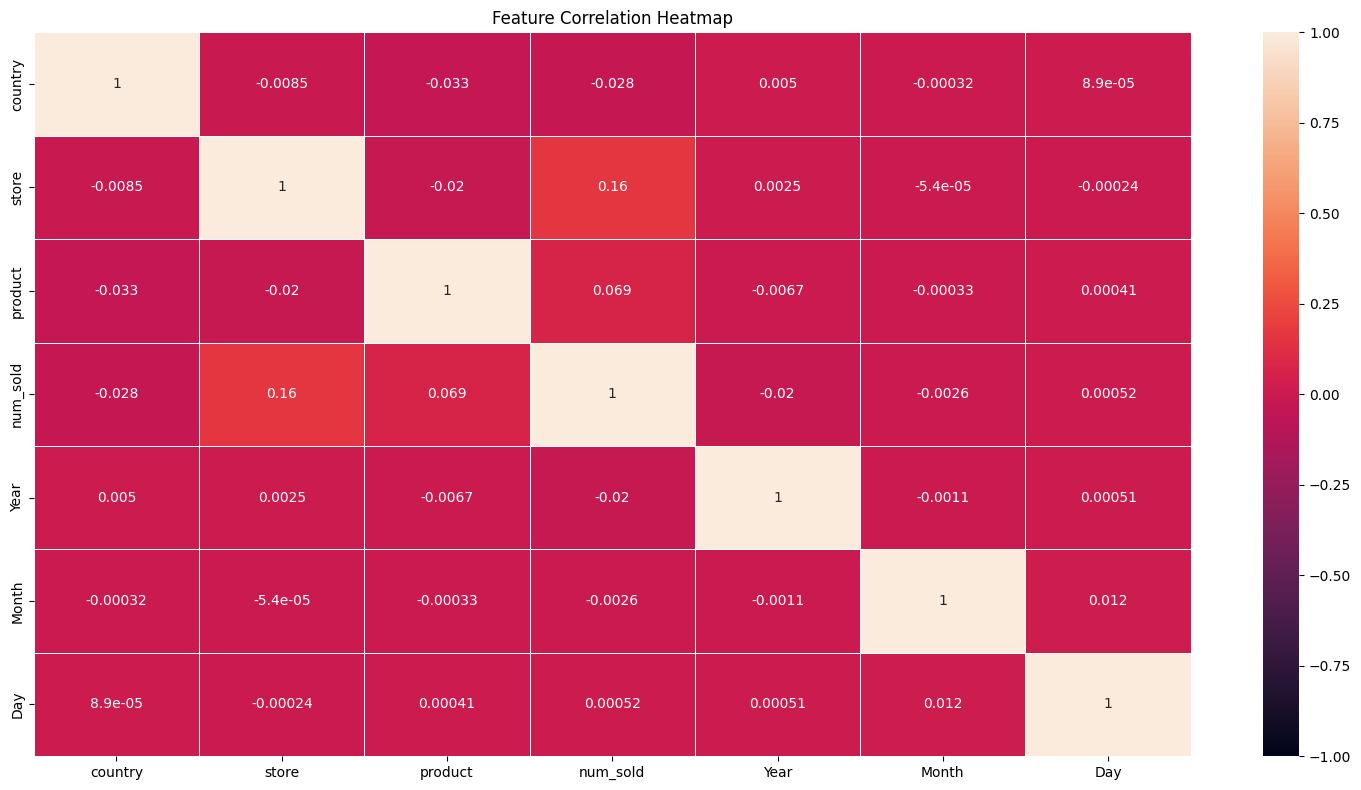

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = train_df.corr()

# Plot the heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, linewidths=0.5, vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

## Training XGBoost model with Optuna

In [19]:
from sklearn.model_selection import train_test_split
X = train_df.drop(['num_sold'], axis=1)
y = train_df['num_sold']
test = test_df.drop(['id'],axis=1)

# Split datainto training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Don't forget to add accelerator in Kaggle with GPU T4 before running Optuna!

In [20]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
import optuna

# Define MAPE metric
def mape(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

def objective(trial):
    param = {
        'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        'sampling_method': 'gradient_based',
        'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
        'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),
        'eta': trial.suggest_categorical('eta', [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'gamma': trial.suggest_categorical('gamma', [18, 19, 20, 21, 22, 23, 24, 25]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'colsample_bynode': trial.suggest_categorical('colsample_bynode', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'n_estimators': trial.suggest_int('n_estimators', 400, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 8, 600),  
        'max_depth': trial.suggest_categorical('max_depth', [3, 4, 5, 6, 7]),  
        'subsample': trial.suggest_categorical('subsample', [0.5,0.6,0.7,0.8,1.0]),
        'random_state': 42
    }

    model = XGBRegressor(**param)  
    
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=False)
    
    predict = model.predict(X_test)
    
    mape_score = mape(y_test, predict)
    
    return mape_score


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50,  timeout=600)
    
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-01-02 05:11:38,455] A new study created in memory with name: no-name-116530f9-ba94-4dee-840a-9978a79d18d7
<ipython-input-20-3da7f51ed837>:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
<ipython-input-20-3da7f51ed837>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dis

Number of finished trials: 50
Best trial:
  Value: 0.01961125092523375
  Params: 
    lambda: 15.168989217042833
    alpha: 13.050313079002876
    eta: 0.5
    gamma: 18
    learning_rate: 0.016
    colsample_bytree: 0.9
    colsample_bynode: 1.0
    n_estimators: 921
    min_child_weight: 537
    max_depth: 7
    subsample: 1.0


In [21]:
# best MAPE = 0.019 from Optuna
xgb_parameters = {
    'lambda': 16.984616421474673,
    'alpha': 7.2944965643293935,
    'eta': 0.7,
    'gamma': 19,
    'learning_rate': 0.008,
    'colsample_bytree': 0.8,
    'colsample_bynode': 1.0,
    'n_estimators': 941,
    'min_child_weight': 283,
    'max_depth': 6,
    'subsample': 0.5
}

In [22]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
from xgboost import XGBRegressor
import numpy as np
import pandas as pd

# Define MAPE metric
def mape(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

# Cross-validation for XGBRegressor
def cross_val_xgbr_mape(X, y, test, n_splits=5, **xgb_parameters):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    mape_scores = []
    preds = []

    for train_index, valid_index in kf.split(X):
        # Ensure data types for indexing
        if isinstance(X, pd.DataFrame):
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        else:
            X_train, X_valid = X[train_index], X[valid_index]
            y_train, y_valid = y[train_index], y[valid_index]

        # Initialize and train the model
        model = XGBRegressor(random_state=42, **xgb_parameters)
        model.fit(X_train, y_train)

        # Predictions and evaluation
        y_pred = model.predict(X_valid)
        score = mape(y_valid, y_pred)
        mape_scores.append(score)

        # Predict on the test set
        preds.append(model.predict(test))

    # Average predictions over all folds
    test_preds_mean = np.mean(preds, axis=0)

    return np.mean(mape_scores), test_preds_mean

average_mape, xgb_preds = cross_val_xgbr_mape(X, y, test, n_splits=5, **xgb_parameters)

print(f"Average MAPE across folds: {average_mape:.4f}")

# Save predictions for submission
submission = pd.DataFrame({'id': test_df['id'], 'num_sold': np.expm1(xgb_preds)})
print(submission.head())
submission.to_csv('submission_xgb.csv', index=False)

Average MAPE across folds: 0.0219
       id    num_sold
0  230130  115.913025
1  230131  674.311096
2  230132  562.409241
3  230133  301.218475
4  230134  378.319489


## Let's try with LightGBM and Optuna

In [23]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_percentage_error
import optuna

# Define MAPE metric
def mape(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

def objective(trial):
    
    param = {
        'tree_method': 'gpu_hist',
        "verbosity": -1,
        'sampling_method': 'gradient_based',
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        'max_depth': trial.suggest_categorical('max_depth', [3, 4, 5, 6, 7]),
        'subsample': trial.suggest_categorical('subsample', [0.5,0.6,0.7,0.8,1.0]),
        'n_estimators': trial.suggest_int('n_estimators', 400, 1000),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "random_state": 42
    }

    model = LGBMRegressor(**param)  
    
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    
    predict = model.predict(X_test)
    
    mape_score = mape(y_test, predict)
    
    return mape_score


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50,  timeout=600)
    
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-01-02 05:13:18,016] A new study created in memory with name: no-name-5b7e12d9-e68a-4fe5-84e9-2cec908a019c
[I 2025-01-02 05:13:20,720] Trial 0 finished with value: 0.03469455356857061 and parameters: {'lambda_l1': 1.5535842342889303, 'lambda_l2': 0.00016443357468571635, 'num_leaves': 27, 'learning_rate': 0.012, 'colsample_bytree': 0.8, 'feature_fraction': 0.7381430997179151, 'bagging_fraction': 0.9036500441901669, 'max_depth': 3, 'subsample': 0.7, 'n_estimators': 406, 'bagging_freq': 1, 'min_child_samples': 41}. Best is trial 0 with value: 0.03469455356857061.
[I 2025-01-02 05:13:24,165] Trial 1 finished with value: 0.039715762900382076 and parameters: {'lambda_l1': 0.007754953417236291, 'lambda_l2': 0.0006867816229183264, 'num_leaves': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.7, 'feature_fraction': 0.745757305381344, 'bagging_fraction': 0.5303469050672924, 'max_depth': 3, 'subsample': 0.6, 'n_estimators': 434, 'bagging_freq': 6, 'min_child_samples': 40}. Best is trial 0 

Number of finished trials: 50
Best trial:
  Value: 0.013538941384496093
  Params: 
    lambda_l1: 3.5816017826295027e-06
    lambda_l2: 1.8889491366654516e-05
    num_leaves: 142
    learning_rate: 0.02
    colsample_bytree: 0.5
    feature_fraction: 0.7028328996303971
    bagging_fraction: 0.7063443746251624
    max_depth: 7
    subsample: 0.6
    n_estimators: 914
    bagging_freq: 3
    min_child_samples: 28


In [24]:
# MAPE = 0.013165753684445974

lgbm_parameters = {
    'lambda_l1': 1.9110308129857972e-06,
    'lambda_l2': 1.4720943722601327e-08,
    'num_leaves': 159,
    'learning_rate': 0.018,
    'colsample_bytree': 0.9,
    'feature_fraction': 0.8661665398937026,
    'bagging_fraction': 0.8916098848078859,
    'max_depth': 7,
    'subsample': 0.7,
    'n_estimators': 998,
    'bagging_freq': 5,
    'min_child_samples': 26
}

In [25]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
from lightgbm import LGBMRegressor
import numpy as np
import pandas as pd

# Define MAPE metric
def mape(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

# Cross-validation for LGBMRegressor
def cross_val_lgbm_mape(X, y, test, n_splits=5, **lgb_parameters):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    mape_scores = []
    preds = []

    for train_index, valid_index in kf.split(X):
        # Ensure data types for indexing
        if isinstance(X, pd.DataFrame):
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        else:
            X_train, X_valid = X[train_index], X[valid_index]
            y_train, y_valid = y[train_index], y[valid_index]

        # Initialize and train the model
        model = LGBMRegressor(random_state=42, **lgbm_parameters)
        model.fit(X_train, y_train)

        # Predictions and evaluation
        y_pred = model.predict(X_valid)
        score = mape(y_valid, y_pred)
        mape_scores.append(score)

        # Predict on the test set
        preds.append(model.predict(test))

    # Average predictions over all folds
    test_preds_mean = np.mean(preds, axis=0)

    return np.mean(mape_scores), test_preds_mean

average_mape, lgb_preds = cross_val_lgbm_mape(X, y, test, n_splits=5, **lgbm_parameters)

print(f"Average MAPE across folds: {average_mape:.4f}")

# Save predictions for submission
submission = pd.DataFrame({'id': test_df['id'], 'num_sold': np.expm1(lgb_preds)})
print(submission.head())
submission.to_csv('submission_lgbm.csv', index=False)

Average MAPE across folds: 0.0132
       id    num_sold
0  230130  132.436553
1  230131  732.358797
2  230132  654.477735
3  230133  342.461479
4  230134  402.604060
